# Clean data for December 14, 2018

## Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyart
import glob
import os
from itertools import groupby
from pathlib import Path

In [143]:
dow8_files = sorted(glob.glob("../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_02*_SUR.nc"))
cow_files = sorted(glob.glob("../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_02*"))

In [147]:
radar = pyart.io.read(cow_files[3])

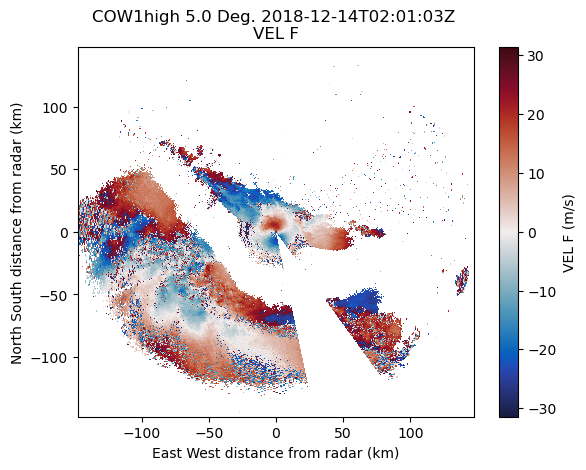

In [149]:
display = pyart.graph.RadarDisplay(radar)
gatefilter=pyart.filters.gatefilter.GateFilter(radar)
gatefilter.exclude_below('SNRHC', 2)
display.plot_ppi('VEL_F',
                 gatefilter=gatefilter,
                 cmap='pyart_balance')

## Clean the Data

### Setup the Filtering Using the Velocity Texture

In [150]:
nyq = np.array(radar.get_nyquist_vel(0))

vel_texture = pyart.retrieve.calculate_velocity_texture(
    radar, vel_field="VEL_F", wind_size=3, nyq=nyq,
)
radar.add_field("velocity_texture", vel_texture, replace_existing=True)

In [166]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_below('SNRHC', 4)
gatefilter.exclude_above("velocity_texture", 8)
gatefilter.exclude_invalid('VEL_F')

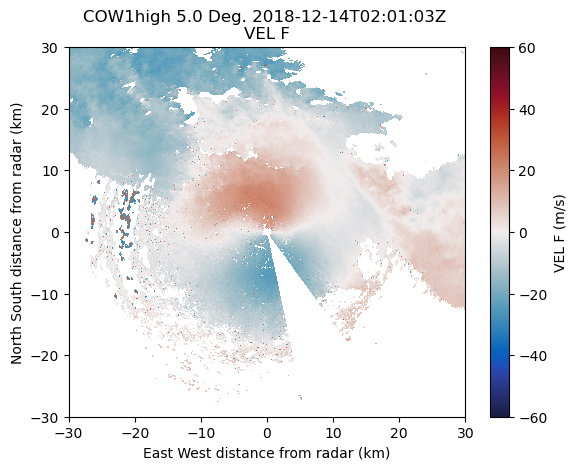

In [167]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('VEL_F',
                 cmap='pyart_balance',
                 sweep=0,
                 vmin=-60,
                 gatefilter=gatefilter,
                 vmax=60)
plt.xlim(-30, 30)
plt.ylim(-30, 30);

## Clean the Data Using a Sounding + Region Based

In [153]:
df = pd.read_table('../../data/soundings/uiuc1-dec-14-0200.txt', skiprows=[1, 2], delim_whitespace=True)

In [154]:
df_qc = df.loc[df.Qu == 1]

In [155]:
height = df_qc.Alt.values
speed = df_qc.spd.values
direction = df_qc.dir.values
lat = df_qc.Lat.values
lon = df_qc.Lon.values

<AxesSubplot: >

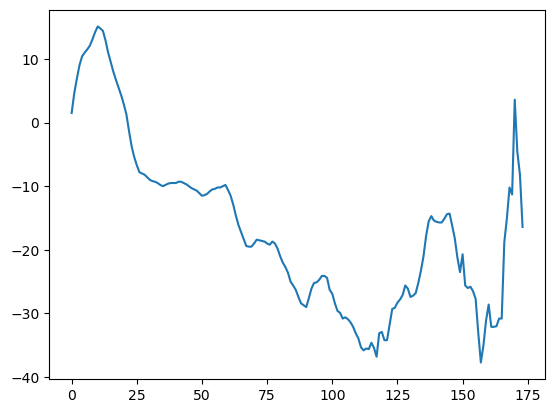

In [156]:
df_qc.Vcmp.plot()

In [157]:
direction

array([139.1, 186.2, 199.3, 204.6, 205.2, 204.1, 202.2, 200.7, 196.6,
       192.7, 189. , 190. , 190.2, 193.6, 198.1, 201.8, 206. , 211.6,
       219.2, 229. , 243.7, 258.7, 279.9, 297.9, 307.8, 314.1, 318.5,
       318. , 317.9, 320.5, 322.9, 323.9, 325. , 325.6, 327.7, 329.5,
       329. , 328.9, 329. , 329. , 328.6, 328.1, 328.1, 328.2, 328. ,
       327.3, 326.7, 326. , 326.1, 326. , 325.9, 324.5, 324. , 324.5,
       324.1, 323.1, 321.9, 321.2, 318.1, 314.8, 313.4, 312.7, 313.6,
       314.8, 316.3, 318. , 316.8, 315.1, 314. , 313. , 311.7, 310. ,
       310.1, 310.1, 310. , 310. , 310. , 309.1, 309. , 309. , 309.7,
       310. , 310.1, 310.6, 312. , 313. , 314.8, 316.6, 318. , 317.9,
       317.7, 314.3, 311.1, 309. , 308.7, 307.7, 306.1, 306. , 306.2,
       308.9, 310. , 313.1, 315.5, 316.1, 317. , 316. , 315.9, 316. ,
       317. , 319. , 319.9, 320. , 321.9, 322. , 321.5, 320. , 320. ,
       320. , 317. , 316.4, 319.9, 323. , 319. , 316.1, 315.1, 314. ,
       312.2, 311.1,

In [158]:
profile = pyart.core.HorizontalWindProfile(height,
                                 speed,
                                 direction,
                                 latitude=lat,
                                 longitude=lon)

In [159]:
profile_radar_field = pyart.util.simulated_vel_from_profile(radar, profile)

In [160]:
radar.add_field('profile_simulated_velocity',
                profile_radar_field,
                replace_existing=True)

In [161]:
gatefilter.exclude_below('profile_simulated_velocity', -100)
gatefilter.exclude_above('profile_simulated_velocity', 100)
gatefilter.exclude_masked('profile_simulated_velocity')

/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/graph/radardisplay.py:99: UserWarning: RadarDisplay does not correct for moving platforms
  warnings.warn("RadarDisplay does not correct for moving platforms")


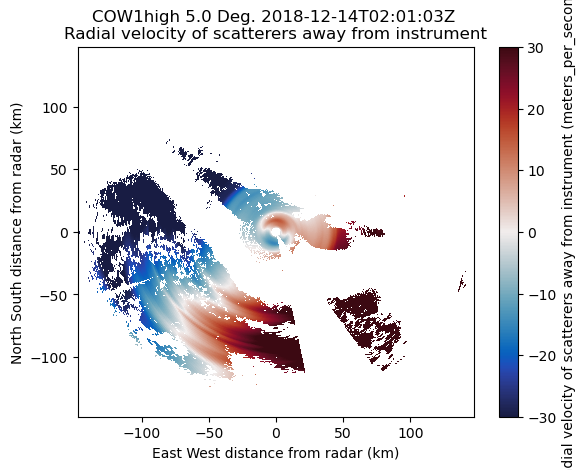

In [162]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('profile_simulated_velocity',
                 cmap='pyart_balance',
                 sweep=0,
                 vmin=-30,
                 gatefilter=gatefilter,
                 vmax=30)

In [163]:
corrected_velocity = pyart.correct.dealias_region_based(radar,
                                   gatefilter=gatefilter,
                                   vel_field='VEL_F',
                                   ref_vel_field='profile_simulated_velocity')

/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15060     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.03033D+06    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15060      0      1      0     0     0   6.000D+00   5.030D+06
  F =   5030330.5504573807     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [164]:
radar.add_field("corrected_velocity", corrected_velocity, replace_existing=True)

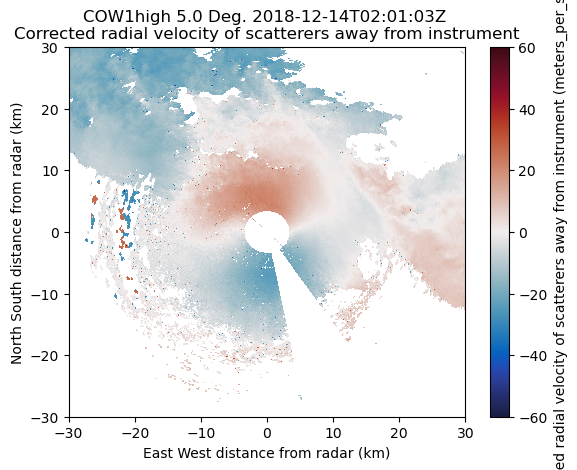

In [169]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_velocity',
                 cmap='pyart_balance',
                 sweep=0,
                 vmin=-60,
                 gatefilter=gatefilter,
                 vmax=60)
plt.xlim(-30, 30)
plt.ylim(-30, 30);

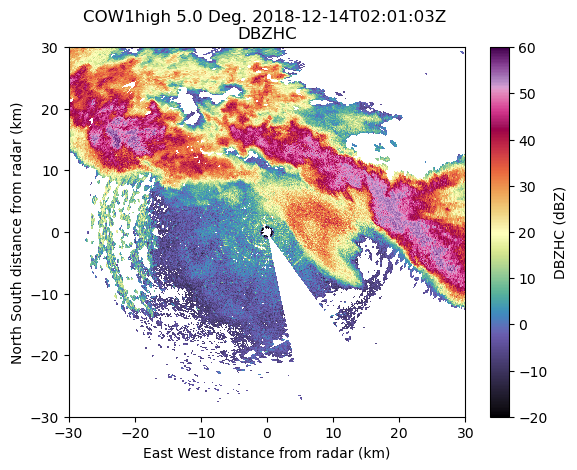

In [170]:
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('DBZHCC',
                 cmap='pyart_ChaseSpectral',
                 sweep=0,
                 vmin=-20,
                 gatefilter=gatefilter,
                 vmax=60)
plt.xlim(-30, 30)
plt.ylim(-30, 30);

## Wrap this All into a Function - Apply to all the Files

In [171]:
def dealias_radar(radar_file,
                  sounding_file,
                  velocity_texture_threshold=10,
                  snr_threshold=3,
                  out_directory='../../data/cleaned-radar-data/'):
    """
    Clean the radar data using a sounding and the region-based dealiasing algorithm
    """
    
    # Read the radar file into a Py-ART object
    radar = pyart.io.read(radar_file)
    
    # Extract the radar name
    path = Path(radar_file)
    radar_name = path.stem.split('_')[2]
    
    # Sounding file
    df = pd.read_table(sounding_file,
                       skiprows=[1, 2],
                       delim_whitespace=True)
    
    # Clean the data using the QC flags
    df_qc = df.loc[df.Qu == 1]
    
    # Load the data from the sounding into variables
    height = df_qc.Alt.values
    speed = df_qc.spd.values
    direction = df_qc.dir.values
    lat = df_qc.Lat.values
    lon = df_qc.Lon.values
    
    # Create a Horizontal Wind Profile object
    profile = pyart.core.HorizontalWindProfile(height,
                                 speed,
                                 direction,
                                 latitude=lat,
                                 longitude=lon)
    
    profile_radar_field = pyart.util.simulated_vel_from_profile(radar,
                                                                profile)
    
    # Add the sounding field to the radar
    radar.add_field('profile_simulated_velocity',
                profile_radar_field,
                replace_existing=True)
    
    # Exclude unusually large/small velocity values
    gatefilter.exclude_below('profile_simulated_velocity', -100)
    gatefilter.exclude_above('profile_simulated_velocity', 100)
    gatefilter.exclude_masked('profile_simulated_velocity')
    
    # Run the region based dealiasing routine
    corrected_velocity = pyart.correct.dealias_region_based(radar,
                                                            gatefilter=gatefilter,
                                                            vel_field='VEL_F',
                                                            ref_vel_field='profile_simulated_velocity')
    
    # Add the new corrected velocity field to the radar
    radar.add_field("corrected_velocity", corrected_velocity, replace_existing=True)
    
    
    out_date = pd.to_datetime(radar.time['units'][-20:]).strftime('%Y%m%d/')
    out_subdirectory = f'{out_directory}{out_date}{radar_name}'
    
    # Check to see if the directory already exists - if not, create it!
    if not os.path.exists(out_subdirectory):
        os.makedirs(out_subdirectory)
    
    # Save the file
    pyart.io.write_cfradial(f'{out_subdirectory}/{path.stem}.nc',
                            radar)
    del radar
    
    

In [135]:
for file in dow8_files:
    dealias_radar(file,
                  '../../data/soundings/uiuc1-dec-14-0200.txt')
    print('done with', file)

/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9990     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94100D+06    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9990      0      1      0     0     0   6.000D+00   1.941D+06
  F =   1941004.4741513855     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020004_DOW8_v141_s02_el1.48_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15065     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34160D+06    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15065      0      1      0     0     0   6.000D+00   7.342D+06
  F =   7341596.3448774135     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020016_DOW8_v141_s03_el2.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11193     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18952D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11193      0      1      0     0     0   6.000D+00   1.190D+07
  F =   11895195.152870433     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020029_DOW8_v141_s04_el4.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9590     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.06168D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9590      0      1      0     0     0   6.000D+00   5.062D+07
  F =   50616792.046740212     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020041_DOW8_v141_s05_el6.61_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10339     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.86560D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10339      0      1      0     0     0   6.000D+00   5.866D+07
  F =   58655975.483228378     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020053_DOW8_v141_s06_el8.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9705     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.71205D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9705      0      1      0     0     0   6.000D+00   4.712D+07
  F =   47120496.627617702     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020105_DOW8_v141_s07_el10.70_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8413     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23037D+08    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8413      0      1      0     0     0   6.000D+00   1.230D+08
  F =   123036828.37872565     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020118_DOW8_v141_s08_el12.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8512     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30868D+10    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8512      0      1      0     0     0   7.000D+00   6.309D+10
  F =   63086808869.441605     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020130_DOW8_v141_s09_el14.61_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10160     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43941D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10160      0      1      0     0     0   6.000D+00   1.439D+11
  F =   143941124065.93719     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020142_DOW8_v141_s10_el16.66_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8468     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21276D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8468      0      1      0     0     0   6.000D+00   1.213D+11
  F =   121276329913.78636     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020155_DOW8_v141_s11_el18.65_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7226     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19361D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7226      0      1      0     0     0   6.000D+00   1.194D+11
  F =   119360535745.84143     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020207_DOW8_v141_s12_el20.65_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10321     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68977D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10321      0      1      0     0     0   6.000D+00   1.690D+11
  F =   168977289127.11249     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020219_DOW8_v141_s13_el22.65_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7979     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65380D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7979      0      1      0     0     0   7.000D+00   1.654D+11
  F =   165379640924.57932     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020232_DOW8_v141_s14_el24.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9546     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30679D+11    |proj g|=  8.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9546      0      1      0     0     0   8.000D+00   2.307D+11
  F =   230679292068.68341     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020244_DOW8_v141_s15_el26.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8561     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52640D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8561      0      1      0     0     0   6.000D+00   2.526D+11
  F =   252639614370.42795     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020256_DOW8_v141_s16_el28.66_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9152     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13356D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9152      0      1      0     0     0   6.000D+00   3.134D+11
  F =   313356220430.76160     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020308_DOW8_v141_s17_el30.65_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11023     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68921D+11    |proj g|=  8.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11023      0      1      0     0     0   8.000D+00   3.689D+11
  F =   368920667277.75311     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020321_DOW8_v141_s18_el32.67_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11159     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03305D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11159      0      1      0     0     0   7.000D+00   4.033D+11
  F =   403305055916.94525     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020333_DOW8_v141_s19_el34.67_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8748     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70531D+11    |proj g|=  8.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8748      0      1      0     0     0   8.000D+00   3.705D+11
  F =   370531133576.37738     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020345_DOW8_v141_s20_el37.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10834     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.12454D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10834      0      1      0     0     0   7.000D+00   4.125D+11
  F =   412453713907.22772     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020358_DOW8_v141_s21_el41.67_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9067     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29384D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9067      0      1      0     0     0   7.000D+00   3.294D+11
  F =   329384432186.02606     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020410_DOW8_v141_s22_el45.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7391     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49304D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7391      0      1      0     0     0   7.000D+00   2.493D+11
  F =   249304191162.32794     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020422_DOW8_v141_s23_el50.69_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10137     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18096D+06    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10137      0      1      0     0     0   6.000D+00   8.181D+06
  F =   8180955.8293937305     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020447_DOW8_v142_s02_el1.48_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11177     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03032D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11177      0      1      0     0     0   6.000D+00   1.030D+07
  F =   10303170.729779365     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020459_DOW8_v142_s03_el2.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10021     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82692D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10021      0      1      0     0     0   6.000D+00   2.827D+07
  F =   28269239.268899582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020511_DOW8_v142_s04_el4.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        12669     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32396D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
12669      0      1      0     0     0   6.000D+00   2.324D+07
  F =   23239645.825809922     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020524_DOW8_v142_s05_el6.61_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10921     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06256D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10921      0      1      0     0     0   6.000D+00   3.063D+07
  F =   30625565.609936439     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020536_DOW8_v142_s06_el8.60_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11413     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.55189D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11413      0      1      0     0     0   6.000D+00   4.552D+07
  F =   45518945.184898786     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020548_DOW8_v142_s07_el10.59_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9852     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38556D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9852      0      1      0     0     0   6.000D+00   3.386D+07
  F =   33855556.843644373     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020600_DOW8_v142_s08_el12.60_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10105     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17543D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10105      0      1      0     0     0   6.000D+00   8.175D+10
  F =   81754348469.429443     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020613_DOW8_v142_s09_el14.60_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10583     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45130D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10583      0      1      0     0     0   6.000D+00   1.451D+11
  F =   145130136938.73856     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020625_DOW8_v142_s10_el16.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10046     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58520D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10046      0      1      0     0     0   6.000D+00   1.585D+11
  F =   158520036172.88712     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020637_DOW8_v142_s11_el18.66_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10079     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62143D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10079      0      1      0     0     0   6.000D+00   1.621D+11
  F =   162143495904.75421     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020650_DOW8_v142_s12_el20.65_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8755     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43806D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8755      0      1      0     0     0   6.000D+00   1.438D+11
  F =   143805959499.95593     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020702_DOW8_v142_s13_el22.66_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9060     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77364D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9060      0      1      0     0     0   6.000D+00   1.774D+11
  F =   177363939442.45163     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020714_DOW8_v142_s14_el24.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11404     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67574D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11404      0      1      0     0     0   6.000D+00   2.676D+11
  F =   267573683685.48770     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020727_DOW8_v142_s15_el26.66_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7688     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65021D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7688      0      1      0     0     0   6.000D+00   2.650D+11
  F =   265021179753.19415     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020739_DOW8_v142_s16_el28.66_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9418     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20327D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9418      0      1      0     0     0   6.000D+00   3.203D+11
  F =   320326971006.87408     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020751_DOW8_v142_s17_el30.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11524     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95012D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11524      0      1      0     0     0   6.000D+00   3.950D+11
  F =   395012230204.24512     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020803_DOW8_v142_s18_el32.67_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9981     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83537D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9981      0      1      0     0     0   7.000D+00   3.835D+11
  F =   383537279017.51666     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020816_DOW8_v142_s19_el34.67_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9305     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91142D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9305      0      1      0     0     0   6.000D+00   3.911D+11
  F =   391142478249.15424     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020828_DOW8_v142_s20_el37.69_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8298     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38926D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8298      0      1      0     0     0   6.000D+00   3.389D+11
  F =   338926113738.61932     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020840_DOW8_v142_s21_el41.67_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10723     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82922D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10723      0      1      0     0     0   6.000D+00   3.829D+11
  F =   382922154395.12543     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020853_DOW8_v142_s22_el45.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8709     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62762D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8709      0      1      0     0     0   6.000D+00   2.628D+11
  F =   262761998162.91553     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_020905_DOW8_v142_s23_el50.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8433     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99792D+08    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8433      0      1      0     0     0   6.000D+00   4.998D+08
  F =   499791902.12996101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021033_DOW8_v144_s02_el1.47_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11683     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.32812D+06    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11683      0      1      0     0     0   6.000D+00   9.328D+06
  F =   9328124.9283888042     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021045_DOW8_v144_s03_el2.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9994     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33837D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9994      0      1      0     0     0   6.000D+00   1.338D+07
  F =   13383746.237906884     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021058_DOW8_v144_s04_el4.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         6924     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83767D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 6924      0      1      0     0     0   6.000D+00   3.838D+07
  F =   38376741.405662611     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021110_DOW8_v144_s05_el6.61_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        12033     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77089D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
12033      0      1      0     0     0   6.000D+00   2.771D+07
  F =   27708946.033717237     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021122_DOW8_v144_s06_el8.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11593     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99437D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11593      0      1      0     0     0   6.000D+00   2.994D+07
  F =   29943720.760092843     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021134_DOW8_v144_s07_el10.71_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9493     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61562D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9493      0      1      0     0     0   6.000D+00   3.616D+07
  F =   36156194.438687570     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021147_DOW8_v144_s08_el12.69_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10164     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.95523D+10    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10164      0      1      0     0     0   7.000D+00   7.955D+10
  F =   79552330438.266144     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021159_DOW8_v144_s09_el14.69_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8960     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36123D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8960      0      1      0     0     0   6.000D+00   1.361D+11
  F =   136122790839.28658     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021211_DOW8_v144_s10_el16.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10699     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75342D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10699      0      1      0     0     0   6.000D+00   1.753D+11
  F =   175342107569.75565     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021224_DOW8_v144_s11_el18.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7879     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21612D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7879      0      1      0     0     0   6.000D+00   1.216D+11
  F =   121612496160.31570     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021236_DOW8_v144_s12_el20.71_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7632     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48485D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7632      0      1      0     0     0   6.000D+00   1.485D+11
  F =   148484649690.48517     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021248_DOW8_v144_s13_el22.71_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10433     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.26037D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10433      0      1      0     0     0   6.000D+00   2.260D+11
  F =   226036802770.38217     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021300_DOW8_v144_s14_el24.65_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8459     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43361D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8459      0      1      0     0     0   6.000D+00   2.434D+11
  F =   243361398685.71689     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021313_DOW8_v144_s15_el26.68_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9103     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08308D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9103      0      1      0     0     0   6.000D+00   3.083D+11
  F =   308308446397.72156     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021325_DOW8_v144_s16_el28.65_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9314     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43882D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9314      0      1      0     0     0   6.000D+00   3.439D+11
  F =   343881926272.79633     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021337_DOW8_v144_s17_el30.65_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10138     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80110D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10138      0      1      0     0     0   7.000D+00   3.801D+11
  F =   380109859729.67975     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021350_DOW8_v144_s18_el32.67_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7040     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31201D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7040      0      1      0     0     0   6.000D+00   3.312D+11
  F =   331200722763.11523     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021402_DOW8_v144_s19_el34.61_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10401     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.35684D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10401      0      1      0     0     0   6.000D+00   4.357D+11
  F =   435684103229.65790     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021414_DOW8_v144_s20_el37.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8631     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.66893D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8631      0      1      0     0     0   7.000D+00   3.669D+11
  F =   366892989752.77551     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021427_DOW8_v144_s21_el41.68_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11234     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04186D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11234      0      1      0     0     0   6.000D+00   4.042D+11
  F =   404185516432.09021     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021439_DOW8_v144_s22_el45.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8839     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85468D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8839      0      1      0     0     0   6.000D+00   2.855D+11
  F =   285467830509.08130     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021451_DOW8_v144_s23_el50.68_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8587     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37767D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8587      0      1      0     0     0   6.000D+00   1.378D+07
  F =   13776657.960225470     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021516_DOW8_v145_s02_el1.50_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11536     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43222D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11536      0      1      0     0     0   6.000D+00   1.432D+07
  F =   14322234.573815528     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021528_DOW8_v145_s03_el2.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10862     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22440D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10862      0      1      0     0     0   6.000D+00   1.224D+07
  F =   12244030.571645200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021540_DOW8_v145_s04_el4.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69346D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14111      0      1      0     0     0   6.000D+00   1.693D+07
  F =   16934639.392098233     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021553_DOW8_v145_s05_el6.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11931     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96065D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11931      0      1      0     0     0   6.000D+00   1.961D+07
  F =   19606473.712272290     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021605_DOW8_v145_s06_el8.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8583     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18839D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8583      0      1      0     0     0   6.000D+00   4.188D+07
  F =   41883919.276848018     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021617_DOW8_v145_s07_el10.70_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10013     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78294D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10013      0      1      0     0     0   6.000D+00   3.783D+07
  F =   37829428.003283247     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021629_DOW8_v145_s08_el12.68_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7784     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.93691D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7784      0      1      0     0     0   6.000D+00   5.937D+10
  F =   59369089460.383530     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021642_DOW8_v145_s09_el14.61_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41030D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9600      0      1      0     0     0   6.000D+00   1.410D+11
  F =   141029879301.00397     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021654_DOW8_v145_s10_el16.67_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8615     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55024D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8615      0      1      0     0     0   6.000D+00   1.550D+11
  F =   155023740579.63043     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021706_DOW8_v145_s11_el18.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7903     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40832D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7903      0      1      0     0     0   7.000D+00   1.408D+11
  F =   140831653512.50693     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021719_DOW8_v145_s12_el20.68_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10351     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11358D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10351      0      1      0     0     0   6.000D+00   2.114D+11
  F =   211357964744.82108     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021731_DOW8_v145_s13_el22.68_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7802     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89967D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7802      0      1      0     0     0   6.000D+00   1.900D+11
  F =   189967497645.47714     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021743_DOW8_v145_s14_el24.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8873     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63859D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8873      0      1      0     0     0   6.000D+00   2.639D+11
  F =   263858955500.77545     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021756_DOW8_v145_s15_el26.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7723     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95510D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7723      0      1      0     0     0   6.000D+00   2.955D+11
  F =   295510126059.70764     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021808_DOW8_v145_s16_el28.65_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8478     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26371D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8478      0      1      0     0     0   7.000D+00   3.264D+11
  F =   326370610450.56628     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021820_DOW8_v145_s17_el30.65_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8088     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36199D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8088      0      1      0     0     0   6.000D+00   3.362D+11
  F =   336199486949.14667     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021832_DOW8_v145_s18_el32.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9536     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90649D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9536      0      1      0     0     0   6.000D+00   3.906D+11
  F =   390648998150.39148     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021845_DOW8_v145_s19_el34.61_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8091     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77645D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8091      0      1      0     0     0   7.000D+00   3.776D+11
  F =   377645356746.20630     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021857_DOW8_v145_s20_el37.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        12238     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.63167D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
12238      0      1      0     0     0   6.000D+00   4.632D+11
  F =   463166872832.79175     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021909_DOW8_v145_s21_el41.66_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9671     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47684D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9671      0      1      0     0     0   6.000D+00   3.477D+11
  F =   347683676833.32098     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021922_DOW8_v145_s22_el45.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10767     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43897D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10767      0      1      0     0     0   6.000D+00   3.439D+11
  F =   343897198423.70758     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_021934_DOW8_v145_s23_el50.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7960     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72305D+08    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7960      0      1      0     0     0   6.000D+00   1.723D+08
  F =   172304511.30716869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022049_DOW8_v147_s02_el1.48_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8895     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47190D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8895      0      1      0     0     0   6.000D+00   2.472D+07
  F =   24718960.942845542     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022102_DOW8_v147_s03_el2.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        13603     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25631D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
13603      0      1      0     0     0   6.000D+00   1.256D+07
  F =   12563071.146459615     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022114_DOW8_v147_s04_el4.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10417     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66689D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10417      0      1      0     0     0   6.000D+00   1.667D+07
  F =   16668860.494674757     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022126_DOW8_v147_s05_el6.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8329     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31055D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8329      0      1      0     0     0   6.000D+00   2.311D+07
  F =   23105541.554437790     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022139_DOW8_v147_s06_el8.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9721     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16520D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9721      0      1      0     0     0   6.000D+00   3.165D+07
  F =   31651981.169679638     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022151_DOW8_v147_s07_el10.68_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8067     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37248D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8067      0      1      0     0     0   6.000D+00   2.372D+07
  F =   23724813.559507098     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022203_DOW8_v147_s08_el12.66_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8389     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.09738D+10    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8389      0      1      0     0     0   7.000D+00   8.097D+10
  F =   80973815559.827637     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022215_DOW8_v147_s09_el14.61_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5883     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35885D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 5883      0      1      0     0     0   6.000D+00   9.359D+10
  F =   93588455070.962784     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022228_DOW8_v147_s10_el16.67_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8790     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01027D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8790      0      1      0     0     0   6.000D+00   2.010D+11
  F =   201026808818.64102     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022240_DOW8_v147_s11_el18.66_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         6427     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35963D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 6427      0      1      0     0     0   6.000D+00   1.360D+11
  F =   135963220995.99823     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022252_DOW8_v147_s12_el20.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7366     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70462D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7366      0      1      0     0     0   6.000D+00   1.705D+11
  F =   170462414223.28525     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022305_DOW8_v147_s13_el22.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8314     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07745D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8314      0      1      0     0     0   6.000D+00   2.077D+11
  F =   207745426562.98120     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022317_DOW8_v147_s14_el24.60_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7649     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43743D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7649      0      1      0     0     0   6.000D+00   2.437D+11
  F =   243743362268.52301     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022329_DOW8_v147_s15_el26.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8693     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04849D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8693      0      1      0     0     0   6.000D+00   3.048D+11
  F =   304848781148.29010     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022341_DOW8_v147_s16_el28.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8583     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26191D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8583      0      1      0     0     0   6.000D+00   3.262D+11
  F =   326191019019.13025     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022354_DOW8_v147_s17_el30.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         6860     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91661D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 6860      0      1      0     0     0   6.000D+00   2.917D+11
  F =   291661232423.05902     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022406_DOW8_v147_s18_el32.65_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7825     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44198D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7825      0      1      0     0     0   6.000D+00   3.442D+11
  F =   344197790529.83221     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022418_DOW8_v147_s19_el34.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10866     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.37984D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10866      0      1      0     0     0   6.000D+00   4.380D+11
  F =   437984249311.73370     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022431_DOW8_v147_s20_el37.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9622     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00546D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9622      0      1      0     0     0   7.000D+00   4.005D+11
  F =   400545846207.85822     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022443_DOW8_v147_s21_el41.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7546     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12722D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7546      0      1      0     0     0   6.000D+00   3.127D+11
  F =   312721567092.49078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022455_DOW8_v147_s22_el45.60_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11041     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35223D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11041      0      1      0     0     0   6.000D+00   3.352D+11
  F =   335222771686.92908     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022508_DOW8_v147_s23_el50.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10237     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16471D+09    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10237      0      1      0     0     0   6.000D+00   1.165D+09
  F =   1164714473.0889025     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022532_DOW8_v148_s02_el1.46_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11838     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14102D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11838      0      1      0     0     0   6.000D+00   1.141D+07
  F =   11410223.004903929     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022544_DOW8_v148_s03_el2.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10034     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66108D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10034      0      1      0     0     0   6.000D+00   1.661D+07
  F =   16610779.248297343     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022557_DOW8_v148_s04_el4.63_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9105     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25772D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9105      0      1      0     0     0   6.000D+00   2.258D+07
  F =   22577216.036228701     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022609_DOW8_v148_s05_el6.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11234     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84720D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11234      0      1      0     0     0   6.000D+00   1.847D+07
  F =   18472007.230611157     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022621_DOW8_v148_s06_el8.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10842     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00964D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10842      0      1      0     0     0   6.000D+00   2.010D+07
  F =   20096352.406258747     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022634_DOW8_v148_s07_el10.69_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10086     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03833D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10086      0      1      0     0     0   6.000D+00   3.038D+07
  F =   30383299.304518707     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022646_DOW8_v148_s08_el12.67_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9963     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24525D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9963      0      1      0     0     0   6.000D+00   1.245D+11
  F =   124524816537.06969     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022658_DOW8_v148_s09_el14.61_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7797     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50181D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7797      0      1      0     0     0   6.000D+00   1.502D+11
  F =   150180618836.01953     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022710_DOW8_v148_s10_el16.66_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         6791     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58310D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 6791      0      1      0     0     0   6.000D+00   1.583D+11
  F =   158309573646.42404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022723_DOW8_v148_s11_el18.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8908     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16238D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8908      0      1      0     0     0   7.000D+00   2.162D+11
  F =   216237918755.51160     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022735_DOW8_v148_s12_el20.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7954     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72420D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7954      0      1      0     0     0   6.000D+00   1.724D+11
  F =   172419945703.48593     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022747_DOW8_v148_s13_el22.59_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7552     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96074D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7552      0      1      0     0     0   6.000D+00   1.961D+11
  F =   196074274332.94778     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022800_DOW8_v148_s14_el24.60_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         6973     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27173D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 6973      0      1      0     0     0   6.000D+00   2.272D+11
  F =   227172843054.51465     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022812_DOW8_v148_s15_el26.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9592     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46558D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9592      0      1      0     0     0   6.000D+00   3.466D+11
  F =   346558070749.45074     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022824_DOW8_v148_s16_el28.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8627     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39007D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8627      0      1      0     0     0   6.000D+00   3.390D+11
  F =   339007260127.92389     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022837_DOW8_v148_s17_el30.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7772     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05404D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7772      0      1      0     0     0   6.000D+00   3.054D+11
  F =   305404449038.61145     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022849_DOW8_v148_s18_el32.64_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7653     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42412D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7653      0      1      0     0     0   7.000D+00   3.424D+11
  F =   342412201252.89465     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022901_DOW8_v148_s19_el34.61_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8244     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53289D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8244      0      1      0     0     0   6.000D+00   3.533D+11
  F =   353288745029.32367     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022913_DOW8_v148_s20_el37.62_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8020     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60457D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8020      0      1      0     0     0   6.000D+00   3.605D+11
  F =   360457460079.32080     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/DOW8/radar/cfradial/cfrad.20181214_022926_DOW8_v148_s21_el41.66_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         6751     M =           10

At X0      6751 variables are exactly at the bounds

At iterate    0    f=  2.37436D+11    |proj g|=  1.10000D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 6751      0      1      0     0     0   1.100D+01   2.374D+11
  F =   237436111772.44116     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


MaskError: Mask and data not compatible: data size is 470997, mask size is 638640.

In [ ]:
for file in cow_files:
    try:
        dealias_radar(file,
                      '../../data/soundings/uiuc1-dec-14-0200.txt')
    except:
        pass
    print('done with', file)

/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        17675     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33472D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
17675      0      1      0     0     0   6.000D+00   3.335D+11
  F =   333471840517.75629     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020009_COW1high_v1_s01_el0.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        16530     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.39503D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
16530      0      1      0     0     0   6.000D+00   4.395D+10
  F =   43950344042.303673     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020027_COW1high_v1_s02_el1.80_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        19285     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67988D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
19285      0      1      0     0     0   6.000D+00   1.680D+10
  F =   16798781602.895107     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020045_COW1high_v1_s03_el3.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15060     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.03033D+06    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15060      0      1      0     0     0   6.000D+00   5.030D+06
  F =   5030330.5504573807     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020103_COW1high_v1_s04_el4.99_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11294     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80538D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11294      0      1      0     0     0   6.000D+00   2.805D+07
  F =   28053792.642900035     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020121_COW1high_v1_s05_el6.50_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14045     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00852D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14045      0      1      0     0     0   6.000D+00   3.009D+10
  F =   30085215314.956097     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020139_COW1high_v1_s06_el8.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15196     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.93573D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15196      0      1      0     0     0   6.000D+00   3.936D+11
  F =   393573295810.45697     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020157_COW1high_v1_s07_el10.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14250     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24265D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14250      0      1      0     0     0   6.000D+00   5.243D+11
  F =   524264776924.42078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020215_COW1high_v1_s08_el12.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        12513     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.43970D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
12513      0      1      0     0     0   6.000D+00   6.440D+11
  F =   643970424622.29187     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020233_COW1high_v1_s09_el14.50_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14416     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.66474D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14416      0      1      0     0     0   6.000D+00   8.665D+11
  F =   866474277228.81458     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020251_COW1high_v1_s10_el17.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15907     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04130D+12    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15907      0      1      0     0     0   6.000D+00   1.041D+12
  F =   1041302669212.6775     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020309_COW1high_v1_s11_el20.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11470     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.68696D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11470      0      1      0     0     0   6.000D+00   7.687D+11
  F =   768695697542.00903     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020327_COW1high_v1_s12_el25.99_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        12807     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.48843D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
12807      0      1      0     0     0   6.000D+00   7.488D+11
  F =   748842741699.99292     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020345_COW1high_v1_s13_el35.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14628     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02576D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14628      0      1      0     0     0   7.000D+00   5.026D+11
  F =   502576410953.61053     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020403_COW1high_v1_s14_el49.99_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15182     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74131D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15182      0      1      0     0     0   6.000D+00   2.741D+11
  F =   274130618814.29324     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020442_COW1high_v2_s01_el0.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15749     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64481D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15749      0      1      0     0     0   6.000D+00   4.645D+10
  F =   46448093072.297318     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020500_COW1high_v2_s02_el1.80_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        16066     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75935D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
16066      0      1      0     0     0   6.000D+00   1.759D+10
  F =   17593517363.599667     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020518_COW1high_v2_s03_el3.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        16939     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34161D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
16939      0      1      0     0     0   6.000D+00   1.342D+07
  F =   13416149.384799108     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020536_COW1high_v2_s04_el4.99_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        17028     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41768D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
17028      0      1      0     0     0   6.000D+00   2.418D+07
  F =   24176805.303431291     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020554_COW1high_v2_s05_el6.50_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14828     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96344D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14828      0      1      0     0     0   6.000D+00   2.963D+10
  F =   29634419009.200680     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020612_COW1high_v2_s06_el8.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11258     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06067D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11258      0      1      0     0     0   6.000D+00   3.061D+11
  F =   306067287476.59833     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020631_COW1high_v2_s07_el10.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        16900     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04812D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
16900      0      1      0     0     0   7.000D+00   6.048D+11
  F =   604812246004.37903     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020649_COW1high_v2_s08_el12.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14739     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07579D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14739      0      1      0     0     0   6.000D+00   8.076D+11
  F =   807578998237.87988     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020707_COW1high_v2_s09_el14.50_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11447     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22506D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11447      0      1      0     0     0   6.000D+00   6.225D+11
  F =   622505983593.81860     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020725_COW1high_v2_s10_el17.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14968     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73229D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14968      0      1      0     0     0   6.000D+00   9.732D+11
  F =   973228509164.00818     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020743_COW1high_v2_s11_el20.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11446     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19538D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11446      0      1      0     0     0   7.000D+00   7.195D+11
  F =   719538090972.46790     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020801_COW1high_v2_s12_el25.99_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15025     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.17037D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15025      0      1      0     0     0   6.000D+00   8.170D+11
  F =   817037150075.63208     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020819_COW1high_v2_s13_el35.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        16169     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.65328D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
16169      0      1      0     0     0   7.000D+00   5.653D+11
  F =   565328411673.84216     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_020837_COW1high_v2_s14_el49.99_SUR.nc
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradi

/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        13946     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58174D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
13946      0      1      0     0     0   6.000D+00   2.582D+11
  F =   258173797205.98090     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021013_COW1high_v4_s01_el0.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        17748     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.69785D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
17748      0      1      0     0     0   6.000D+00   5.698D+10
  F =   56978541754.867088     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021031_COW1high_v4_s02_el1.80_SUR.nc
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradia

/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        17696     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38461D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
17696      0      1      0     0     0   6.000D+00   3.385D+07
  F =   33846065.119549781     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021125_COW1high_v4_s05_el6.50_SUR.nc
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradia

/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        13293     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48304D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
13293      0      1      0     0     0   6.000D+00   3.483D+11
  F =   348304244840.88043     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021201_COW1high_v4_s07_el10.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        20922     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19985D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
20922      0      1      0     0     0   6.000D+00   8.200D+11
  F =   819985050253.12378     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021219_COW1high_v4_s08_el12.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        13145     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22684D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
13145      0      1      0     0     0   7.000D+00   6.227D+11
  F =   622683919965.84888     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021237_COW1high_v4_s09_el14.50_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15329     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.32847D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15329      0      1      0     0     0   6.000D+00   9.328D+11
  F =   932846571753.33667     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021255_COW1high_v4_s10_el17.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11587     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.59768D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11587      0      1      0     0     0   7.000D+00   7.598D+11
  F =   759767869713.22729     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021313_COW1high_v4_s11_el20.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        13723     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24798D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
13723      0      1      0     0     0   6.000D+00   9.248D+11
  F =   924798432429.86743     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021331_COW1high_v4_s12_el25.99_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        12256     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11783D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
12256      0      1      0     0     0   7.000D+00   7.118D+11
  F =   711783173953.98523     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021349_COW1high_v4_s13_el35.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10274     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34628D+11    |proj g|=  9.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10274      0      1      0     0     0   9.000D+00   3.346D+11
  F =   334628432525.24207     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021407_COW1high_v4_s14_el49.99_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9022     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74615D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9022      0      1      0     0     0   6.000D+00   1.746D+11
  F =   174614594395.32422     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021446_COW1high_v5_s01_el0.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        16320     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63029D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
16320      0      1      0     0     0   6.000D+00   2.630D+10
  F =   26302941096.417248     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021504_COW1high_v5_s02_el1.80_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        16020     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06827D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
16020      0      1      0     0     0   6.000D+00   1.068D+10
  F =   10682695691.813492     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021522_COW1high_v5_s03_el3.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        21017     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35792D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
21017      0      1      0     0     0   6.000D+00   9.358D+07
  F =   93579242.350422859     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021540_COW1high_v5_s04_el4.99_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        19652     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83377D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
19652      0      1      0     0     0   6.000D+00   6.834D+07
  F =   68337743.407192439     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021558_COW1high_v5_s05_el6.50_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11657     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07141D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11657      0      1      0     0     0   6.000D+00   3.071D+10
  F =   30714060659.718922     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021616_COW1high_v5_s06_el8.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10157     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92530D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10157      0      1      0     0     0   6.000D+00   2.925D+11
  F =   292530422257.51440     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021634_COW1high_v5_s07_el10.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14016     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.32760D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14016      0      1      0     0     0   7.000D+00   5.328D+11
  F =   532760438769.88287     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021652_COW1high_v5_s08_el12.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11093     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.19457D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11093      0      1      0     0     0   6.000D+00   6.195D+11
  F =   619457241782.89746     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021710_COW1high_v5_s09_el14.50_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14368     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71091D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14368      0      1      0     0     0   6.000D+00   8.711D+11
  F =   871091104409.13904     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021728_COW1high_v5_s10_el17.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11729     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29837D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11729      0      1      0     0     0   6.000D+00   8.298D+11
  F =   829837031990.92017     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021746_COW1high_v5_s11_el20.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        13427     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71627D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
13427      0      1      0     0     0   7.000D+00   8.716D+11
  F =   871626553961.25940     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021804_COW1high_v5_s12_el25.99_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11933     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.57133D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11933      0      1      0     0     0   6.000D+00   6.571D+11
  F =   657132671665.64014     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021822_COW1high_v5_s13_el35.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        12912     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.19067D+11    |proj g|=  1.00000D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
12912      0      1      0     0     0   1.000D+01   4.191D+11
  F =   419066871819.12207     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_021840_COW1high_v5_s14_el49.99_SUR.nc
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradi

/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11189     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75090D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11189      0      1      0     0     0   6.000D+00   1.751D+11
  F =   175089973871.38852     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022013_COW1high_v7_s01_el0.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11614     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46253D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11614      0      1      0     0     0   6.000D+00   2.463D+10
  F =   24625266016.141468     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022031_COW1high_v7_s02_el1.80_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        16631     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71948D+09    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
16631      0      1      0     0     0   6.000D+00   1.719D+09
  F =   1719481207.8088410     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022049_COW1high_v7_s03_el3.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        20655     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50798D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
20655      0      1      0     0     0   6.000D+00   1.508D+07
  F =   15079756.706779091     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022107_COW1high_v7_s04_el4.99_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        13988     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.77134D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
13988      0      1      0     0     0   6.000D+00   4.771D+07
  F =   47713445.127244651     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022125_COW1high_v7_s05_el6.50_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15524     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21814D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15524      0      1      0     0     0   6.000D+00   3.218D+10
  F =   32181391478.882328     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022143_COW1high_v7_s06_el8.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        13878     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59882D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
13878      0      1      0     0     0   6.000D+00   3.599D+11
  F =   359882085273.32819     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022201_COW1high_v7_s07_el10.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11336     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26328D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11336      0      1      0     0     0   6.000D+00   4.263D+11
  F =   426328476720.92285     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022219_COW1high_v7_s08_el12.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        13986     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73313D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
13986      0      1      0     0     0   6.000D+00   7.733D+11
  F =   773313009520.67981     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022237_COW1high_v7_s09_el14.50_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11836     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.05522D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11836      0      1      0     0     0   7.000D+00   7.055D+11
  F =   705522112305.26770     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022255_COW1high_v7_s10_el17.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9811     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.99156D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 9811      0      1      0     0     0   6.000D+00   6.992D+11
  F =   699155956195.80322     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022313_COW1high_v7_s11_el20.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15339     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04935D+12    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15339      0      1      0     0     0   7.000D+00   1.049D+12
  F =   1049351894953.5809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022331_COW1high_v7_s12_el25.99_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15403     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.04120D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15403      0      1      0     0     0   6.000D+00   9.041D+11
  F =   904119650967.21777     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022349_COW1high_v7_s13_el35.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        11562     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84786D+11    |proj g|=  9.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
11562      0      1      0     0     0   9.000D+00   3.848D+11
  F =   384786278826.78979     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022407_COW1high_v7_s14_el49.99_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14653     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05608D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14653      0      1      0     0     0   6.000D+00   3.056D+11
  F =   305608303470.29620     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022446_COW1high_v8_s01_el0.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        16062     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27112D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
16062      0      1      0     0     0   6.000D+00   1.271D+10
  F =   12711165668.377287     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022504_COW1high_v8_s02_el1.80_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        18467     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33405D+09    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
18467      0      1      0     0     0   6.000D+00   2.334D+09
  F =   2334048612.5692949     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022522_COW1high_v8_s03_el3.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        21490     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41017D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
21490      0      1      0     0     0   6.000D+00   1.410D+07
  F =   14101684.234255979     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022540_COW1high_v8_s04_el4.99_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14068     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59491D+07    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14068      0      1      0     0     0   6.000D+00   3.595D+07
  F =   35949112.280619927     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022558_COW1high_v8_s05_el6.50_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14186     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18308D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14186      0      1      0     0     0   6.000D+00   3.183D+10
  F =   31830771142.195389     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022616_COW1high_v8_s06_el8.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        12984     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11807D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
12984      0      1      0     0     0   6.000D+00   3.118D+11
  F =   311806888526.09296     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022634_COW1high_v8_s07_el10.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        13503     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75714D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
13503      0      1      0     0     0   6.000D+00   5.757D+11
  F =   575714317686.62122     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022652_COW1high_v8_s08_el12.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8855     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.43608D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8855      0      1      0     0     0   7.000D+00   4.436D+11
  F =   443608326431.13470     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022710_COW1high_v8_s09_el14.50_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10698     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.59169D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10698      0      1      0     0     0   6.000D+00   6.592D+11
  F =   659168951962.96191     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022728_COW1high_v8_s10_el17.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15341     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06344D+12    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15341      0      1      0     0     0   6.000D+00   1.063D+12
  F =   1063444040452.9652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022746_COW1high_v8_s11_el20.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        15406     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09101D+12    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
15406      0      1      0     0     0   6.000D+00   1.091D+12
  F =   1091012358413.1149     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022804_COW1high_v8_s12_el25.99_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42853D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14600      0      1      0     0     0   6.000D+00   8.429D+11
  F =   842852688804.39001     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022822_COW1high_v8_s13_el35.00_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        14881     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.39808D+11    |proj g|=  7.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
14881      0      1      0     0     0   7.000D+00   5.398D+11
  F =   539808018619.43951     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_022840_COW1high_v8_s14_el49.99_SUR.nc
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradi

/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        18461     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17551D+11    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
18461      0      1      0     0     0   6.000D+00   4.176D+11
  F =   417551467858.34949     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_023013_COW1high_v10_s01_el0.49_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        18123     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.19552D+10    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
18123      0      1      0     0     0   6.000D+00   4.196D+10
  F =   41955186677.623756     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
done with ../../data/raw-radar-data/20181213-IOP17/COW/radar/cfradial/low/cfrad.20181214_023031_COW1high_v10_s02_el1.80_SUR.nc


/Users/mgrover/miniforge3/envs/pyart-dev/lib/python3.10/site-packages/pyart/correct/region_dealias.py:323: UserWarning: Velocities outside of the Nyquist interval found in sweep 0.
  warnings.warn(msg, UserWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        19389     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.42261D+09    |proj g|=  6.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
19389      0      1      0     0     0   6.000D+00   7.423D+09
  F =   7422611679.0037498     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
